# **Batch A4: Mini Project on Code Comment Generator **

Roll Numbers: 

*   19251A0530
*   19251A0552

*   19251A0553
*   19251A0557








IMPORTING DEPENDENCIES,INSTALLING AND UPGRADING PACKAGES
---


numpy
pandas
transformers
torch
doqu
seq2seq

*   numpy
*   pandas
*   transformers
*   torch
*   doqu
*   seq2seq







In [ ]:
!nvidia-smi

Thu May 19 12:06:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install -q transformers==4.17.0

     |████████████████████████████████| 3.8 MB 9.0 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
     |████████████████████████████████| 6.6 MB 49.2 MB/s 
     |████████████████████████████████| 880 kB 60.2 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 


In [ ]:
%pip install torch torchvision torchaudio

In [ ]:
# import torch 
# torch.__version__

'1.11.0+cu113'

Getting the dataset from CodeSearchNet

In [ ]:

! wget -q https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
! unzip -qq java.zip

In [ ]:
%pip install doqu 

     |████████████████████████████████| 54 kB 3.0 MB/s 
  Created wheel for doqu: filename=doqu-0.28.2-py3-none-any.whl size=80915 sha256=9fa506e70b65f27054d0b1aa12a6741cb989e196a7012e52a51ddf85f1d0c9e9
  Stored in directory: /root/.cache/pip/wheels/30/41/19/7de53b0e776e59d7b310e06ca83158c18164af5bf0d762f6ba
Successfully built doqu


In [ ]:
%pip install -e seq2seq

Cloning into 'seq2seq'...
remote: Enumerating objects: 5995, done.
remote: Total 5995 (delta 0), reused 0 (delta 0), pack-reused 5995
Receiving objects: 100% (5995/5995), 1.63 MiB | 22.30 MiB/s, done.
Resolving deltas: 100% (4189/4189), done.
Obtaining file:///content/seq2seq
     |████████████████████████████████| 60 kB 4.7 MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191621 sha256=71bfefb3b1c8e3a6db385eb41455b962ff72ef21050e087d9875d5e82d7577bd
  Stored in directory: /root/.cache/pip/wheels/68/35/6a/ffb9a1f51b2b00fee42e7f67f5a5d8e10c67d048cda09ccd57
Successfully built pyrouge
  Running setup.py develop for seq2seq


**PREPROCESSING**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional
def jsonl_list_to_dataframe(file_list, columns=['code', 'docstring']):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "valid", "test"]:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(files).rename(columns = {'code': 'mthd', 'docstring': 'cmt'})
        dfs.append(df)
        
    return dfs

path = Path('.')
df_trn, df_val, df_tst = get_dfs(path/"java/final/jsonl")
sample = 0.01
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)

len(df_trn), len(df_val), len(df_tst)

(4545, 153, 269)

In [ ]:
df_trn.head()

,mthd,cmt
13157,ClassModelMethod resolveCalledMethod(MethodCal...,/*\nFind a suitable call target in the kernel ...
13775,protected void initialiseApplicationContext() ...,Initialises the ApplicationContext instance.
17133,@Override\n public WorkItemHandlersModel ad...,{@inheritDoc}
18207,private ArrayTypeReference doTryConvertToArray...,/* @Nullable
23448,"public static <Message, Event extends Aggregat...",Publish a stream that is sharded across many t...


DATA CLEANING

In [ ]:
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if the given string contains only ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(4412, 137, 264)

In [ ]:
# collapse
from tqdm.auto import tqdm

def get_inline_pairs(mthd):
    '''
    Get all pairs of inline comments and corresponding code snippets

    :param mthd: the method to retrieve the pairs of comments and corresponding
    code snippets from
    :returns: all pairs of comments and corresponding code snippets
    '''
    pairs = [[]]

    comment = False
    bracket = False
    indent_lvl = -1
    lines = mthd.split("\n")
    for line in lines:
        if "//" in line and not bracket and not "://" in line:
            pairs[-1].append(line)
            if '\t' in line:
                indent_lvl = line.count('\t')
            else:
                indent_lvl = line.split("//")[0].count(' ')
            comment = True
            bracket = False
        elif comment:
            if '{' in line and not bracket:
                bracket = True
                pairs[-1].append(line)
            elif '}' in line:
                line_indent = -1
                if '\t' in line:
                    line_indent = line.count('\t')
                else:
                    line_indent = line.split("//")[0].count(' ')
                if indent_lvl == line_indent:
                    pairs[-1].append(line)
                if not bracket:
                    pairs.append([])
                    comment = False
                    bracket = False
            elif line.isspace() or line == '' and not bracket:
                pairs.append([])
                comment = False
            else:
                pairs[-1].append(line)
    
    # Convert pairs into proper format of (code snippet, inline comment) dataframe
    code_snippets   = []
    comments        = []
    for pair in pairs:
        if pair and len(pair) < 5:
            code    = []
            comment = []
            skip = False
            for line in pair:
                if "TODO" in line: break
                if "//" in line:
                    comment.append(line.replace('//', ''))
                else:
                    code.append(line)
            if len(code) > 1 and len(comment) > 0:
                        code_snippets.append('\n'.join(code))
                        comments.append('\n'.join(comment))

    pairs = pd.DataFrame(zip(code_snippets, comments), columns = ["mthd", "cmt"])
    return pairs


def add_inline(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Helper function to go through all methods in a given dataframe and add all
    pairs of inline comments and corresponding code snippets

    :param df: the dataframe to retrieve and add all pairs of inline comments
    and corresponding code snippets to
    :returns: a new dataframe with the newly added pairs of inline comments and
    corresponding code snippets
    '''
    new_df = df[df['mthd'].str.contains("//")]
    all_pairs = []
    for mthd in tqdm(new_df.mthd.values):
        pairs = get_inline_pairs(mthd)
        all_pairs.append(pairs)

    df_pairs = pd.concat([pairs for pairs in all_pairs])
    return pd.concat([df, df_pairs])

df_trn = add_inline(df_trn)
df_val = add_inline(df_val)
df_tst = add_inline(df_tst)

len(df_trn), len(df_val), len(df_tst)

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

(4612, 142, 276)

In [ ]:
# collapse
df_trn = df_trn[df_trn.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_val = df_val[df_val.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]
df_tst = df_tst[df_tst.apply(lambda row: len(row.mthd) > len(row.cmt), axis = 1)]

len(df_trn), len(df_val), len(df_tst)

(3835, 97, 212)

In [ ]:
# collapse
def has_code(cmt: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param cmt: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in cmt: return True
    else: return False

df_trn = df_trn[~df_trn['cmt'].apply(lambda x: has_code(x))]
df_val = df_val[~df_val['cmt'].apply(lambda x: has_code(x))]
df_tst = df_tst[~df_tst['cmt'].apply(lambda x: has_code(x))]

len(df_trn), len(df_val), len(df_tst)

(3681, 94, 207)

In [ ]:
import re

In [ ]:
# collapse
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["cmt"]
        # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)
        
        
        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["mthd"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_jdocs(df_trn);
df_val = remove_jdocs(df_val);
df_tst = remove_jdocs(df_tst);

  0%|          | 0/3681 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
# collapse
def clean_html(cmt: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param cmt: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)
    return result

df_trn.cmt = df_trn.cmt.apply(clean_html)
df_val.cmt = df_val.cmt.apply(clean_html)
df_tst.cmt = df_tst.cmt.apply(clean_html)

In [ ]:
# collapse
df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

(3189, 88, 190)

In [ ]:
df_trn.head()

,mthd,cmt
0,classmodelmethod resolvecalledmethod(methodcal...,/* find a suitable call target in the kernel c...
1,protected void initialiseapplicationcontext() ...,initialises the applicationcontext instance.
4,"public long sendrpc(bytebuffer message, rpcres...",sends an opaque message to the rpchandler on t...
5,public static @nonnull enumeration<url> _findr...,calls .
6,public void addandregisteraddons(list<addonmod...,registers all addons.


DATA EXPLORING

In [ ]:
# collapse
import numpy as np

from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: the pandas dataframe to get the counts of tokens from
    :param tokenizer: the tokenizer to use for tokenizing the rows in the pandas
    dataframe
    :param col: the column to grab rows from when tokenizing
    :returns: the counts of each token in the given pandas dataframe
    column
    '''
    toks = []
    for i, row in df.iterrows():
        toks.extend(tokenizer.tokenize(row[col]))
            
    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1  
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95))
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# collapse
import matplotlib.pyplot as plt

def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    Plot a bar chart of the most common tokens

    :param counts: the counts of each token
    :param top_k: the number of tokens to display in the plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

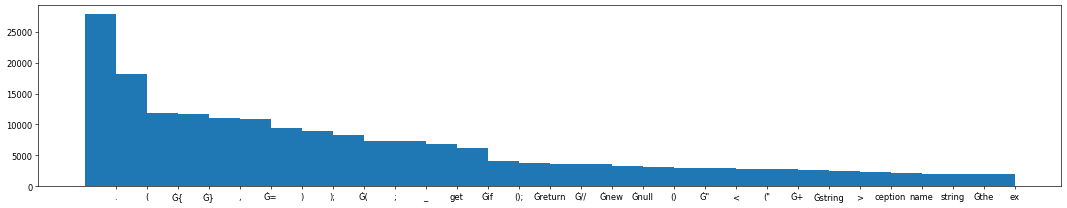

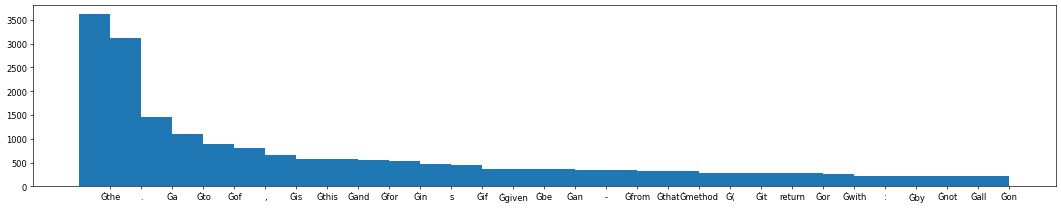

In [ ]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [ ]:
# collapse
def plot_hist(lens: List[int], n_bins: Optional[int] = 50):
    '''
    Plot a histogram of the given number of tokens in a column 

    :param lens: the number of tokens in a column
    :param n_bins: the number of bins to sort the number of tokens into
    '''
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

179 103 341.4923132370625


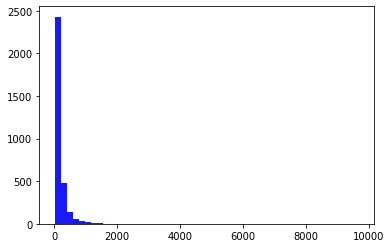

17 12 19.131126469708992


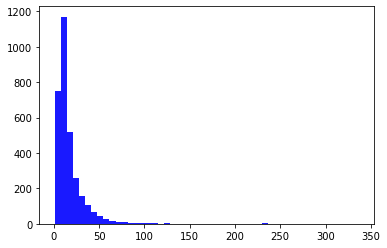

In [ ]:
print(mean(mthd_lens), median(mthd_lens), stdev(mthd_lens))
plot_hist(mthd_lens)
print(mean(cmt_lens), median(cmt_lens), stdev(cmt_lens))
plot_hist(cmt_lens)

Removing the outliers: Any dataframes that have comments that lie outside the 95th percentile mark. 


In [ ]:
# collapse
def filter_len(
    row: pd.Series, tokenizer: AutoTokenizer, mthd_len: int, cmt_len: int
    ) -> bool:
    '''
    Determine if a given panda dataframe row has a method or comment that has
    more tokens than max length

    :param row: the row to check if it has a method or comment that is too long
    :param tokenizer: the tokenizer to tokenize a method or comment
    :param mthd_len: the max number of tokens a method can have
    :param cmt_len: the max number of tokens a comment can have
    :returns: whether or not the given row have a method or comment that have
    more tokens than a max length
    '''
    return len(tokenizer.tokenize(row.mthd)) < mthd_len and len(tokenizer.tokenize(row.cmt)) < cmt_len

df_trn = df_trn[df_trn.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_val = df_val[df_val.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]
df_tst = df_tst[df_tst.apply(
    lambda row: filter_len(
        row, tokenizer, max_mthd_len,
        max_cmt_len
    ), axis = 1
)]

len(df_trn), len(df_val), len(df_tst)

(2886, 80, 179)

In [ ]:
max_mthd_len, max_cmt_len

(557, 48)

MODEL TRAINING


In [ ]:
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import copy
class Seq2Seq(nn.Module):
    """
        Building a Seqence-to-Sequence model.
        
        Parameters:
        * `encoder`- encoder of seq2seq model. 
        * `decoder`- decoder of seq2seq model. 
        * `config`- configuration of encoder model. 
        * `beam_size`- beam size for beam search. 
        * `max_length`- max length of target for beam search. 
        * `sos_id`- start of symbol ids in target for beam search.
        * `eos_id`- end of symbol ids in target for beam search. 
    """
    def __init__(self, encoder,decoder,config,beam_size=None,max_length=None,sos_id=None,eos_id=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder=decoder
        self.config=config
        self.register_buffer("bias", torch.tril(torch.ones(2048, 2048)))
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.lsm = nn.LogSoftmax(dim=-1)
        self.tie_weights()
        
        self.beam_size=beam_size
        self.max_length=max_length
        self.sos_id=sos_id
        self.eos_id=eos_id
        
    def _tie_or_clone_weights(self, first_module, second_module):
        """ Tie or clone module weights depending of whether we are using TorchScript or not
        """
        if self.config.torchscript:
            first_module.weight = nn.Parameter(second_module.weight.clone())
        else:
            first_module.weight = second_module.weight
                  
    def tie_weights(self):
        """ Make sure we are sharing the input and output embeddings.
            Export to TorchScript can't handle parameter sharing so we are cloning them instead.
        """
        self._tie_or_clone_weights(self.lm_head,
                                   self.encoder.embeddings.word_embeddings)        
        
    def forward(self, source_ids=None,source_mask=None,target_ids=None,target_mask=None,args=None):   
        outputs = self.encoder(source_ids, attention_mask=source_mask)
        encoder_output = outputs[0].permute([1,0,2]).contiguous()
        if target_ids is not None:  
            attn_mask=-1e4 *(1-self.bias[:target_ids.shape[1],:target_ids.shape[1]])
            tgt_embeddings = self.encoder.embeddings(target_ids).permute([1,0,2]).contiguous()
            out = self.decoder(tgt_embeddings,encoder_output,tgt_mask=attn_mask,memory_key_padding_mask=(1-source_mask).bool())
            hidden_states = torch.tanh(self.dense(out)).permute([1,0,2]).contiguous()
            lm_logits = self.lm_head(hidden_states)
            # Shift so that tokens < n predict n
            active_loss = target_mask[..., 1:].ne(0).view(-1) == 1
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = target_ids[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1))[active_loss],
                            shift_labels.view(-1)[active_loss])

            outputs = loss,loss*active_loss.sum(),active_loss.sum()
            return outputs
        else:
            #Predict 
            preds=[]       
            zero=torch.cuda.LongTensor(1).fill_(0)     
            for i in range(source_ids.shape[0]):
                context=encoder_output[:,i:i+1]
                context_mask=source_mask[i:i+1,:]
                beam = Beam(self.beam_size,self.sos_id,self.eos_id)
                input_ids=beam.getCurrentState()
                context=context.repeat(1, self.beam_size,1)
                context_mask=context_mask.repeat(self.beam_size,1)
                for _ in range(self.max_length): 
                    if beam.done():
                        break
                    attn_mask=-1e4 *(1-self.bias[:input_ids.shape[1],:input_ids.shape[1]])
                    tgt_embeddings = self.encoder.embeddings(input_ids).permute([1,0,2]).contiguous()
                    out = self.decoder(tgt_embeddings,context,tgt_mask=attn_mask,memory_key_padding_mask=(1-context_mask).bool())
                    out = torch.tanh(self.dense(out))
                    hidden_states=out.permute([1,0,2]).contiguous()[:,-1,:]
                    out = self.lsm(self.lm_head(hidden_states)).data
                    beam.advance(out)
                    input_ids.data.copy_(input_ids.data.index_select(0, beam.getCurrentOrigin()))
                    input_ids=torch.cat((input_ids,beam.getCurrentState()),-1)
                hyp= beam.getHyp(beam.getFinal())
                pred=beam.buildTargetTokens(hyp)[:self.beam_size]
                pred=[torch.cat([x.view(-1) for x in p]+[zero]*(self.max_length-len(p))).view(1,-1) for p in pred]
                preds.append(torch.cat(pred,0).unsqueeze(0))
                
            preds=torch.cat(preds,0)                
            return preds   
        
        

class Beam(object):
    def __init__(self, size,sos,eos):
        self.size = size
        self.tt = torch.cuda
        # The score for each translation on the beam.
        self.scores = self.tt.FloatTensor(size).zero_()
        # The backpointers at each time-step.
        self.prevKs = []
        # The outputs at each time-step.
        self.nextYs = [self.tt.LongTensor(size)
                       .fill_(0)]
        self.nextYs[0][0] = sos
        # Has EOS topped the beam yet.
        self._eos = eos
        self.eosTop = False
        # Time and k pair for finished.
        self.finished = []

    def getCurrentState(self):
        "Get the outputs for the current timestep."
        batch = self.tt.LongTensor(self.nextYs[-1]).view(-1, 1)
        return batch

    def getCurrentOrigin(self):
        "Get the backpointers for the current timestep."
        return self.prevKs[-1]

    def advance(self, wordLk):
        """
        Given prob over words for every last beam `wordLk` and attention
        `attnOut`: Compute and update the beam search.
        Parameters:
        * `wordLk`- probs of advancing from the last step (K x words)
        * `attnOut`- attention at the last step
        Returns: True if beam search is complete.
        """
        numWords = wordLk.size(1)

        # Sum the previous scores.
        if len(self.prevKs) > 0:
            beamLk = wordLk + self.scores.unsqueeze(1).expand_as(wordLk)

            # Don't let EOS have children.
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] == self._eos:
                    beamLk[i] = -1e20
        else:
            beamLk = wordLk[0]
        flatBeamLk = beamLk.view(-1)
        bestScores, bestScoresId = flatBeamLk.topk(self.size, 0, True, True)

        self.scores = bestScores

        # bestScoresId is flattened beam x word array, so calculate which
        # word and beam each score came from
        prevK = bestScoresId // numWords
        self.prevKs.append(prevK)
        self.nextYs.append((bestScoresId - prevK * numWords))


        for i in range(self.nextYs[-1].size(0)):
            if self.nextYs[-1][i] == self._eos:
                s = self.scores[i]
                self.finished.append((s, len(self.nextYs) - 1, i))

        # End condition is when top-of-beam is EOS and no global score.
        if self.nextYs[-1][0] == self._eos:
            self.eosTop = True

    def done(self):
        return self.eosTop and len(self.finished) >=self.size

    def getFinal(self):
        if len(self.finished) == 0:
            self.finished.append((self.scores[0], len(self.nextYs) - 1, 0))
        self.finished.sort(key=lambda a: -a[0])
        if len(self.finished) != self.size:
            unfinished=[]
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] != self._eos:
                    s = self.scores[i]
                    unfinished.append((s, len(self.nextYs) - 1, i)) 
            unfinished.sort(key=lambda a: -a[0])
            self.finished+=unfinished[:self.size-len(self.finished)]
        return self.finished[:self.size]

    def getHyp(self, beam_res):
        """
        Walk back to construct the full hypothesis.
        """
        hyps=[]
        for _,timestep, k in beam_res:
            hyp = []
            for j in range(len(self.prevKs[:timestep]) - 1, -1, -1):
                hyp.append(self.nextYs[j+1][k])
                k = self.prevKs[j][k]
            hyps.append(hyp[::-1])
        return hyps
    
    def buildTargetTokens(self, preds):
        sentence=[]
        for pred in preds:
            tokens = []
            for tok in pred:
                if tok==self._eos:
                    break
                tokens.append(tok)
            sentence.append(tokens)
        return sentence

In [ ]:
# hide
! mkdir java

In [ ]:
# collapse
import json

df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split())
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open('java/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open('java/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open('java/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

In [ ]:
lang = 'java' # programming language
lr = 5e-5
batch_size = 8 
beam_size = 10
source_length = 256
target_length = max_cmt_len
data_dir = '.'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 10 
pretrained_model = 'microsoft/codebert-base'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs}

05/19/2022 12:13:12 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./java/valid.jsonl', do_eval=True, do_lower_case=True, do_test=False, do_train=True, eval_batch_size=8, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path=None, local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=48, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=10, output_dir='model/java', seed=42, test_filename=None, tokenizer_name='', train_batch_size=8, train_filename='./java/train.jsonl', train_steps=-1, warmup_steps=0, weight_decay=0.0)
05/19/2022 12:13:12 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
Downloading: 100% 476M/476M [00:17<00:00, 28.5MB/s]
05/19/2022 12:13:48 - INFO - __main__ -   *** Example ***
05/19/2022 12:13:48 - INFO - __main__ -   idx: 0
05/19/2022 12:13:48 - INFO - __main__ - 

In [ ]:
batch_size=64
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/codebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size}

05/19/2022 12:54:34 - INFO - __main__ -   Namespace(adam_epsilon=1e-08, beam_size=10, config_name='', dev_filename='./java/valid.jsonl', do_eval=False, do_lower_case=False, do_test=True, do_train=False, eval_batch_size=64, eval_steps=-1, gradient_accumulation_steps=1, learning_rate=5e-05, load_model_path='model/java/checkpoint-best-bleu/pytorch_model.bin', local_rank=-1, max_grad_norm=1.0, max_source_length=256, max_steps=-1, max_target_length=48, model_name_or_path='microsoft/codebert-base', model_type='roberta', no_cuda=False, num_train_epochs=3, output_dir='model/java', seed=42, test_filename='./java/test.jsonl', tokenizer_name='', train_batch_size=8, train_filename=None, train_steps=-1, warmup_steps=0, weight_decay=0.0)
05/19/2022 12:54:34 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
05/19/2022 12:54:40 - INFO - __main__ -   reload model from model/java/checkpoint-best-bleu/pytorch_model.bin
05/19/2022 12:54:52 - INFO - __main__ -  

In [ ]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)    
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [ ]:
idx = 0
TEXT_TO_SUMMARIZE = df_val.mthd.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', df_val.cmt.values[idx])

Code: @override public void configureconstraintweight(rule rule, simplescore constraintweight) { super.configureconstraintweight(rule, constraintweight); biconsumer<rulecontext, integer> matchexecutor; if (constraintweight.equals(simplescore.zero)) { matchexecutor = (rulecontext kcontext, integer matchweight) -> {}; } else { matchexecutor = (rulecontext kcontext, integer matchweight) -> addconstraintmatch(kcontext, constraintweight.getscore() * matchweight); } matchexecutorbynumbermap.put(rule, matchexecutor); }
Original Comment: ************************************************************************


In [ ]:
# collapse
from run import convert_examples_to_features, Example

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
    
    return ps

In [ ]:
df_val = df_val.reset_index()
preds = get_preds(df_val.head(10))
for idx, row in df_val.head(10).iterrows():
    print('Code:', row.mthd)
    '''print('Original Comment:', row.cmt)'''
    print('Generated Comment:', preds[idx])
    print('='*40)

  0%|          | 0/10 [00:00<?, ?it/s]

/content/CodeXGLUE/Code-Text/code-to-text/code/model.py:165: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


Code: @override public void configureconstraintweight(rule rule, simplescore constraintweight) { super.configureconstraintweight(rule, constraintweight); biconsumer<rulecontext, integer> matchexecutor; if (constraintweight.equals(simplescore.zero)) { matchexecutor = (rulecontext kcontext, integer matchweight) -> {}; } else { matchexecutor = (rulecontext kcontext, integer matchweight) -> addconstraintmatch(kcontext, constraintweight.getscore() * matchweight); } matchexecutorbynumbermap.put(rule, matchexecutor); }
Original Comment: ************************************************************************
Generated Comment: set the constraint.
Code: public static schemacatalog makecoreschemacatalog() { return schemacatalog( sbol2terms.sbol2.namespaceduri("/schemaexample/core"), importedschemas(), documentschemas( documentschema( sbol2terms.sbol2.namespaceduri("/schema/identified"), extends(), identifierschemas(), typeschemas(), propertyschemas() ), documentschema( sbol2terms.sbol2.namespac

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.mthd, target = row.cmt)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask)  
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())
    
    return ps, losses

In [ ]:
df_head = df_val.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = False)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.mthd)
    """print('Original Comment:', row.cmt)"""
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*10)

  0%|          | 0/80 [00:00<?, ?it/s]

/content/CodeXGLUE/Code-Text/code-to-text/code/model.py:165: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


Code: public static date donowortoday(string value, string coltype) throws dateparseexception { if (!isnowortodayformat(value)) { return null; } calendar c = calendar.getinstance(); string lowervalue = value.tolowercase(); if (lowervalue.startswith(now)) { parsenow(value, lowervalue, c); } else if (lowervalue.startswith(today)) { parsetoday(value, lowervalue, c); } else { throw new dateparseexception("programmer error: " + value + " does not start with 'now' or 'today'"); } date today = c.gettime(); if (coltype == null || coltype.length() == 0) { throw new dateparseexception("must supply non-null column type when using 'now' or 'today' value."); } else if (coltype.equalsignorecase("timestamp")) { return new java.sql.timestamp(today.gettime()); } else if (coltype.equalsignorecase("time")) { // a little odd using today format with a time type column, but we'll do it - will get current time... return new java.sql.time(today.gettime()); } else if (coltype.equalsignorecase("date") || coltyp